# Comparison with ODEs

In [1]:
import atomica as at
import sciris as sc
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

Atomica is a compartment modelling toolbox that fundamentally is equivalent to a system of ODEs. In this example we demonstrate this by looking at a simple SIR model and reproducing the ODE structure in Atomica. The SIR model has structure

![SIR model](sir.png)

with two transitions - a transition from 'susceptible' to 'infected' where the rate depends on the number of people that are currently infected (and are therefore assumed to be infectious) and a transition from 'infected' to 'recovered' where the rate reflects the duration of infection. This model can be characterised by the following system of equations:

$$
\begin{align}
dS &= -\beta S\frac{I}{N} \\
dI &= -\beta S\frac{I}{N} - \gamma I\\
dR &= \gamma I
\end{align}
$$

where $\beta = N_c\theta$ with $N_c$ being the number of contacts per person per unit time, $\theta$ being the probability of transmission per contact, and $\gamma = 1/\tau_I$ where $\tau_I$ is the duration of infection. 

Suppose we assign the following parameter values

In [2]:
N_c = 80
θ = 0.08
τ_i = 0.5

N = 1000 # Population size
I_0 = 10 # Number initially infected

We can then implement a function representing the ODEs above, and solve the initial value problem using standard ODE methods, such as `solve_ivp` from [scipy](https://scipy.org/):

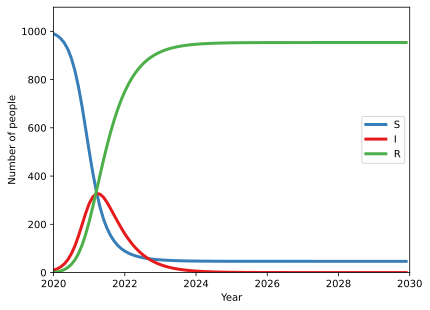

In [3]:
def rhs(t, y) -> np.array:
    new_inf = N_c * θ* y[0] * y[1] / N
    dS = -new_inf
    dI = new_inf - (1/τ_i)*y[1]
    dR = (1/τ_i)*y[1]
    return np.array([dS, dI, dR])

y0 = np.array([N-I_0,I_0,0])

sol = solve_ivp(
    rhs,
    (2020,2030),
    y0,
    t_eval = np.arange(2020,2030,0.1),
)

for i, color in enumerate(sc.gridcolors(3)):
    plt.plot(sol.t, sol.y[i,:], color=color, linestyle='-',linewidth=3)
plt.legend(['S','I','R'])
plt.ylim(0,1100)
plt.xlim(2020,2030)
plt.xlabel('Year')
plt.ylabel('Number of people');

Consider implementing the same model in Atomica. First we define the three compartments for the model on the 'Compartments' sheet:

![compartments](compartments.png)

To save having to write a separate databook, we can insert the value for `I_0` (the initial number of people infected) as a default value in the framework file. We will also set the initial number recovered to `0`. We omit the number of susceptible people and do not have the compartment appear in the databook, so that it can be computed based on the total population size.

Next, we define a characteristic for `N`, the total number of people:

![characteristics](characteristics.png)

By including this characteristic in the databook, we are able to replicate the calculation from the explicit ODE model above, with `y0 = np.array([N-I_0,I_0,0])` - we have defined values for `N`, `I_0`, and set the initial number of recovered to `0`, and Atomica will carry out the initialization using these values to calculate the initial number susceptible as `N-I_0`. 

Now we define the model parameters. Notice that we are free to use unicode symbols in the framework file, and can define them using the same characters used above:

![parameters](parameters.png)

The first three parameters are straightforward constants. The force of infection is defined using a function. The form of the equation is largely the same as in the explicit model above. However, two key points to note are

- The parameter value is positive/unsigned, similar to the `new_inf` variable above. When this quantity acts on compartment sizes, the sign (negative for the outflow in `dS = -new_inf`, positive in `dI = +new_inf...`) comes from the transition matrix
- In Atomica, when a transition is defined between one compartment and another, the number of people to move is calculated (for a parameter in 'rate' units) by multiplying the parameter value by the size of the compartment that people are flowing out of. This allows us to define the function for the `foi` parameter consistent with the traditional definition 'the rate at which susceptible people become infected' i.e., a rate that is be multiplied by the number of susceptible people to calculate the number of new infections. Hence this parameter is defined as `N_c*θ*I/N` without `S` appearing in the function.

Finally, we need to write out the transition matrix. For the SIR model, only two transitions are required. Notice that we can specify the duration-related transition directly by setting the duration `τ_i` as the transition parameter. This will automatically drive the transition using the inverse of the duration as the equivalent rate (`1/τ_i`) so it is not necessary to define an additional parameter for this.   


![transitions](transitions.png)

The framework is available to download [here](sir_analytic_framework.xlsx). We can now go ahead and run the model in Atomica:

Elapsed time for running "default": 0.0397s


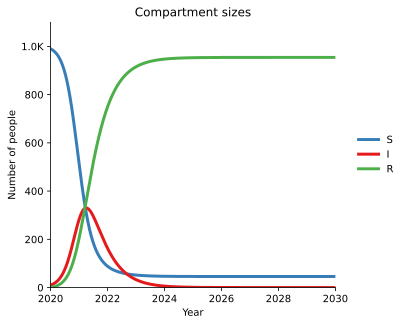

In [4]:
F = at.ProjectFramework('sir_analytic_framework.xlsx')
P = at.Project(framework=F,databook=at.ProjectData.new(F, [2024],1,0), do_run=False)
P.settings.update_time_vector(2020,2030,0.01)
res = P.run_sim()
at.plot_series(at.PlotData(res));
plt.xlim(2020,2030)
plt.ylim(0,1100)

plt.title('Compartment sizes');

With a small step size, Atomica is able to reproduce the same solution as `solve_ivp` - the solid lines show output from Atomica and the dashed line show output from `solve_ivp`:

<Figure size 614.4x460.8 with 0 Axes>

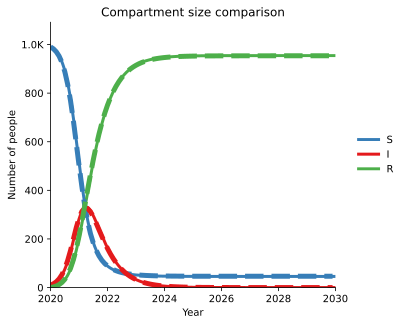

In [5]:
plt.figure()
at.plot_series(at.PlotData(res));
for i, color in enumerate(sc.gridcolors(3)):
    plt.plot(sol.t, sol.y[i,:], color=color, linestyle='--',linewidth=5)
plt.title('Compartment size comparison');               

Atomica effectively uses the Euler method for integration - this is helpful for the implementation of discontinuities in parameter values which can sometimes be difficult to parametrise. If we use a larger step size in Atomica, we can see how the shape of the output does slightly differ from the previous solution that used a smalelr step size (which in general indicates the model needs to be run with the smaller step size) and we can also confirm that the results exactly match actually performing the Euler integration directly (instead of using `solve_ivp`):

Elapsed time for running "default": 0.00888s


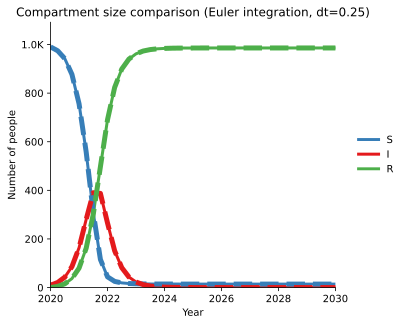

In [6]:
# Plot Atomica output with a larger step size
P.settings.sim_dt = 0.25
res = P.run_sim()
at.plot_series(at.PlotData(res));

# Perform Euler integration with the same step size
y0 = np.array([N-I_0,I_0,0])
t = res.t
dt = t[1]-t[0]
y = np.zeros((3,len(t)))
y[:,0] = y0
for i in range(len(t)-1):
    y[:,i+1] = y[:,i]+dt*rhs(t[i],y[:,i])

# Plot output from manual integration
for i, color in enumerate(sc.gridcolors(3)):
    plt.plot(t, y[i,:], color=color, linestyle='--',linewidth=5)
    
plt.title('Compartment size comparison (Euler integration, dt=0.25)');               